>Георгий, приветствую! Меня зовут Кудрявцев Александр и я буду проверять твой проект.
>
>Если ты непротив, мне было бы удобнее общаться на "ты" во время проверки проекта :)
>
>Ниже в ноутбуке будут мои комментарии, закодированные разными цветами.
>
>**<span style="color:green">Зеленым будут выделены места, которые хочется особенно отметить, как хорошие. </span>**
>
>**<span style="color:red">Недочеты, откомментированные красным обязательны к доработке – без их исправления проект не будет зачтен. </span>**
>  
> **<span style="color:orange">Недочеты и подсказки, откомментированные оранжевым, учесть желательно, но их доработка не является обязательным условнием для зачета.</span>**
>
> Если какие-то подзадачи не откомментированны – значит с ними все окей, нет возражений.
>
> Если ошибка влечет за собой дальнейшие неточности рассчетов или выводов – пожалуйста, поправь их тоже, чтобы аналитический отчет был целостным.
>
>Пожалуйста, не удаляй и не переноси мои комментарии, а также выделяй свои новые комментарии цветом (например, синим) — это позволит лучше ориентироваться при возможных повторных проверках. Также предлагаю быть в диалоге при повторных проверках.

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px">
 Александр, привет! По ошибке: действительно, в своей оценке не учел "инерцию угасания платформ", а посчитал всех "мертвыми в одночасье, кроме растущих".
Что, конечно же, не так в реальной жизни (здесь большой привет передают проводная телефония и дома 1930-ых годов постройки). Исправил.</div>
    

## Введение

Сборный проект №1 в соответствие с проектным заданием. План проекта крайне прост: делать то, что написано в задании.

## Инициализация и полезные функции

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
copy = data.copy() # техническая функция, сохранение данных
def save():
    copy = data.copy()
def load():
    data = copy.copy()

In [4]:
def nullstat(df): # вывод статистики по нулям
    return df\
    .isna()\
    .sum()\
    .to_frame(name='Nans')\
    .assign(Nans_share = lambda row: row['Nans'] / df.shape[0])\
    .sort_values(by='Nans')\
    .style\
    .bar(color='lightblue')

In [5]:
# построение гистограм для одного и более фреймов
def hist(onecolumn_frames_list=[], xlab='', ylab='', title='', bins=10, xrange=None, figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    rmin, rmax = 999999999999999, 0
    series_list, legend_list = [], []
    alpha, alpha_step = 1, int((40 / len(onecolumn_frames_list))) / 100 # полная прозрачность нам не нужна 
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
    for i in series_list:
        rmin = i.min() if i.min() < rmin else rmin
        rmax = i.max() if i.max() > rmax else rmax
        ax.hist(i,bins=bins, alpha=alpha)
        alpha -= alpha_step
    rrange = xrange if xrange != None else (rmin,rmax)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xlim(rrange)
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    plt.grid()
    fig.tight_layout()

In [6]:
# построение ящика с усами для одного и более фреймов
def boxplot(onecolumn_frames_list=[], xlab='', ylab='', title='', vert=False, figsize=(10,5), fontsize=12, showfliers=True, notch=False):
    fig, ax = plt.subplots()
    series_list, legend_list, lowers, uppers = [], [], [], []
    label_info = ""
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
        q1 = i[column_name].quantile(0.25)
        q3 = i[column_name].quantile(0.75) 
        iqr = q3 - q1
        median = i[column_name].median()
        mean = i[column_name].mean()
        lower = q1 - 1.5*iqr
        if lower < 0:
            lower = 0
        upper = q3 + 1.5*iqr   
        lowers.append(lower)
        uppers.append(upper)
        label_info += f"\n {column_name}: границы усов = [{round(lower,2)}; {round(upper,2)}], среднее = {round(mean,2)}, медиана = {round(median,2)}, Q1 = {round(q1,2)}, Q3 = {round(q3,2)}" 
        
    bp = ax.boxplot(
        series_list,
        vert=vert,
        patch_artist=True,
        labels=legend_list,
        showfliers=showfliers,
        notch=notch, 
        sym='gs'
    )
    
    colors = ['pink', 'lightgreen', 'orange', 'lightblue', 'yellow','red', 'black', 'green', 'grey', 'blue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
        
    if vert == False: 
        ax.xaxis.grid(True)
    else: 
        ax.yaxis.grid(True)
        
    ax.set_title(title)
    ax.set_xlabel(xlab + label_info)
    
    ax.set_ylabel(ylab)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    fig.tight_layout()

In [7]:
# построение графика плотности вероятности на базе нормального распределения 
def pdf(onecolumn_df, xlab='', ylab='', title='', figsize=(10,5), fontsize=12):
    name = onecolumn_df.columns[0]
    mean = round(float(onecolumn_df.mean()),2)
    std = round(float(onecolumn_df.std()),2)
    xmin = onecolumn_df[name].min()
    xmax = onecolumn_df[name].max()
    left = mean - 4 * std
    if left < 0:
        left = 0;
    right = mean + 4 * std
    left3 = round(float(mean - 3 * std),2)
    if left3 < 0:
        left3 = 0
    right3 = round(float((mean + 3 * std)),2)
    x = []
    i = int(left)
    while(i < int(right)):
        x.append(int(i))
        i += 1
    plt.figure(figsize=figsize)
    plt.plot(x, st.norm.pdf(x,mean,std), linewidth=2)
    plt.title(title)
    plt.xlabel(xlab + "\n[std = " + str(std) + ", min = " + str(xmin) + ", max = " + str(xmax) + "]") 
    plt.ylabel(ylab)
    xcoords = { 
        (name + ' mean-3*std'): [left3, 'r'],
        (name +' mean'): [mean, 'k'],
        (name + ' mean+3*std'): [right3, 'b']
    }
    for name in xcoords.keys():
        plt.axvline(
            x=xcoords[name][0],
            label="{} = {}".format(name, xcoords[name][0]),
            color=xcoords[name][1],
            linestyle='--')
    plt.legend()
    plt.rcParams.update({'font.size': fontsize})
    plt.show()

In [8]:
# построение графика-линии по одному и более серий
def line(series_name_x_y_dict, xlab='', ylab='', title='', figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    legend_list = []
    for name in series_name_x_y_dict:
        legend_list.append(name)
        ax.plot(
            series_name_x_y_dict[name]['x'],
            series_name_x_y_dict[name]['y'],
            linewidth=5
        )
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title(title)        
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    fig.tight_layout()
    plt.show()

In [9]:
# построение диаграммы рассеяния
def scatter(name_kvlists_dict, xlab='', ylab='', title='', figsize=(10,5), fontsize=12):
    fig = plt.figure()
    base_plot_conf = "1" + str(len(name_kvlists_dict))
    position = 1
    for name in name_kvlists_dict:
        ax = fig.add_subplot(base_plot_conf + str(position))
        ax.scatter(name_kvlists_dict[name]['values'][0],name_kvlists_dict[name]['values'][1])
        corr = name_kvlists_dict[name]['values'][0].corr(name_kvlists_dict[name]['values'][1])
        corr_info = "[коэфф. корреляции  = " + str(round(corr,2)) + " ]"
        ax.set_title(name + "\n" + corr_info)
        ax.set_xlabel(name_kvlists_dict[name]['names'][0])
        ax.set_ylabel(name_kvlists_dict[name]['names'][1])
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        position += 1
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    fig.tight_layout()
    plt.show()

>**<span style="color:green">Очень здорово, что ты уже к четвертому проекту уверенно используешь собственные функции для автоматизации рутины — молодец! Это очень сильно повышает читаемость твоего кода и экономит тебе самому массу времени (тем более многие из этих функций могут мигрировать и в другие проекты).</span>**

## Изучение общих сведений о файле 

Посмотрим, что внутри:

In [10]:
data.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
15087,Tropico Reloaded,PC,2009.0,Strategy,0.00,0.02,0.00,0.00,NaN,tbd,T
4525,Castlevania: Dawn of Sorrow,DS,2005.0,Platform,0.34,0.03,0.03,0.03,89.0,8.5,T
7526,Thrillville,PSP,2006.0,Strategy,0.18,0.00,0.00,0.02,72.0,2.8,E10+
10450,Banjo-Pilot,GBA,2005.0,Racing,0.07,0.03,0.00,0.00,68.0,5.9,E
15538,Drakensang: The Dark Eye,PC,2009.0,Role-Playing,0.02,0.00,0.00,0.00,NaN,NaN,NaN
12544,Flipnic: Ultimate Pinball,PS2,2003.0,Misc,0.03,0.02,0.00,0.01,64.0,8.1,E
5787,NASCAR Thunder 2003,GC,2002.0,Racing,0.24,0.06,0.00,0.01,85.0,6.6,E
14396,Jikandia: The Timeless Land,PSP,2010.0,Role-Playing,0.03,0.00,0.00,0.00,60.0,7.2,T
9554,Backyard Baseball,GC,2003.0,Sports,0.10,0.03,0.00,0.00,70.0,9.4,E
558,Madden NFL 12,X360,2011.0,Sports,2.42,0.11,0.00,0.16,78.0,5.9,E


Преобразуем названия колонок:

In [11]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Чуть более детально о null-начениях:

In [13]:
nullstat(data)

,Nans,Nans_share
platform,0,0.000000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000
other_sales,0,0.000000
name,2,0.000120
genre,2,0.000120
year_of_release,269,0.016093
user_score,6701,0.400897
rating,6766,0.404786


>**<span style="color:green">Здесь всё структурировано и по делу, класс. </span>**
>


## Подготовка данных

Посмотрим на **name**, в части, где есть пропуски:

In [14]:
data.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пара неизвестных игр без отзывов, жанра и рейтинга, год - 1993. Данные никак не помогут нам в прогнозировании, так что смело их отбрасываем:


In [15]:
data = data.query('name.notna()')
nullstat(data[['name']])

,Nans,Nans_share
name,0,0.000000


Для контроля сделаем lowercase + strip для всех строк, чтобы избежать случайных дублей:

In [16]:
data['name'] = data['name'].str.lower()
data['name'] = data['name'].str.strip()
data.query('name.duplicated()').sort_values(by='name').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14658,007: quantum of solace,PC,2008.0,Action,0.01,0.01,0.00,0.00,70.0,6.3,T
1785,007: quantum of solace,PS3,2008.0,Action,0.43,0.51,0.02,0.19,65.0,6.6,T
3120,007: quantum of solace,Wii,2008.0,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
4475,007: quantum of solace,PS2,2008.0,Action,0.17,0.00,0.00,0.26,NaN,NaN,NaN
9507,007: quantum of solace,DS,2008.0,Action,0.11,0.01,0.00,0.01,65.0,tbd,T
2243,007: the world is not enough,PS,2000.0,Action,0.51,0.35,0.00,0.06,61.0,6.7,T
15656,11eyes: crossover,PSP,2010.0,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
10076,18 wheeler: american pro trucker,GC,2002.0,Racing,0.09,0.02,0.00,0.00,52.0,6.8,E
12283,187: ride or die,XB,2005.0,Racing,0.05,0.01,0.00,0.00,51.0,6.9,M
9966,2 in 1 combo pack: sonic heroes / super monkey...,X360,2013.0,Misc,0.09,0.01,0.00,0.01,NaN,NaN,NaN


Контрольный ориентир общего числа строк:

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Остается только убедиться, что нет "логически полных" дублей в **name** + **platform** + **year_of_release**:

In [18]:
data\
    .groupby(by=['name', 'platform','year_of_release'])\
    .agg({'name':'count'})\
    .query("name > 1")

,,,name
name,platform,year_of_release,
madden nfl 13,PS3,2012.0,2


Разберем руками:

In [19]:
data.query('name == "madden nfl 13" and platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,madden nfl 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


№16230 похожа на "дополнительные статистические данные по Европе", которые пришли позднее, хотя, возможна и ошибка. Примем первый вариант, скорректируем №604 и удалим лишнее:

In [20]:
if data.at[604,'eu_sales'] == 0.22:
    data.at[604,'eu_sales'] += 0.01

In [21]:
if 16230 in data.index:
    data.drop(index=[16230], inplace=True)

In [22]:
data.query('name == "madden nfl 13" and platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,PS3,2012.0,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E


In [23]:
data[['name']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16714
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    16712 non-null  object
dtypes: object(1)
memory usage: 261.1+ KB


Что с **platform** ? Ничего интересного с точки зрения некорректности данных:

In [24]:
data['platform'].value_counts()

PS2     2161
DS      2151
PS3     1330
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

Посмотрим на **year_of_release**:

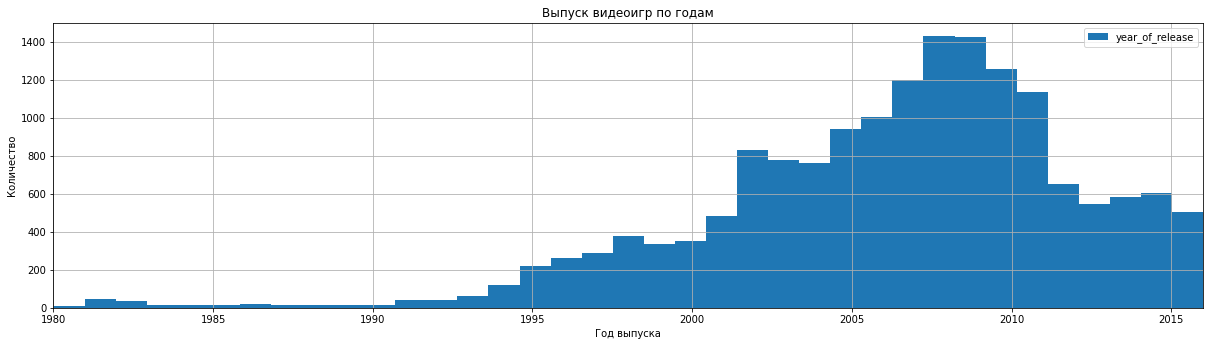

In [25]:
hist(\
    onecolumn_frames_list = [
        data[['year_of_release']].dropna().astype('int32')
    ],
    bins=37,
    figsize=(17,5),
    xlab='Год выпуска',
    ylab='Количество',
    title='Выпуск видеоигр по годам',
    fontsize=13
)

Да, видимо кризис 2008 сказался и на производителях в игровой индустрии, хотя уже запущенные проекты, видимо, никто не стал останавливать.

>**<span style="color:green">Отличная гипотеза о влиянии мирового финансового кризиса на спад в индустрии игр.</span>**

In [26]:
nullstat(data[['year_of_release']])

,Nans,Nans_share
year_of_release,269,0.016096


Посмотрим, что можно выжать из предположения "игра выходит в один год игра может выходить на нескольких платформах":

In [27]:
year_resurrection = data[['name','platform', 'year_of_release']]\
    .query('year_of_release.isna()')\
    .merge(
        data[['name','platform', 'year_of_release']]\
            .query('year_of_release.notna()'),
        on=['name'],
        how='left')\
    .query('year_of_release_y.notna()')\
    .groupby(by=['name', 'year_of_release_y'])\
    .agg({'name':'count'})\
    .rename(columns={'name':'count'})\
    .reset_index()\
    .rename(columns={'year_of_release_y':'year_of_release'})\
    .drop_duplicates(subset=['name'],keep=False)[['name','year_of_release']]
year_resurrection

,name,year_of_release
0,akb1/48: idol to guam de koishitara...,2011.0
1,aquaman: battle for atlantis,2003.0
2,battle vs. chess,2011.0
3,bejeweled 3,2010.0
4,bioshock 2,2010.0
...,...,...
105,wcw backstage assault,1999.0
106,wet,2009.0
110,without warning,2005.0
111,world of tanks,2011.0


Восстановим значения **year_of_release**:

In [28]:
def resurrect_year(row):
    if pd.isna(row['year_of_release']):
        name = row['name']
        candidate = year_resurrection.query('name == @name')
        if candidate.shape[0] == 1:
            resurrected_year = candidate['year_of_release'].values[0]
            row['year_of_release'] = resurrected_year
    return row
data = data.apply(resurrect_year,axis=1)
nullstat(data[['year_of_release']])

,Nans,Nans_share
year_of_release,158,0.009454


Технически, возможно, что в редких случаях будут столь качественно написанные игры (например, на хорошо портируемом движке), которые умудрятся получить одинаковую **critic_score** или **user_score** для разных платформ (идентичный user_expirience). Для целей восстановления **year_of_release**, это может быть полезно, хотя, очевидно, что в общем случае это неверно:

In [29]:
data[['name','platform','year_of_release','critic_score', 'user_score']]\
    .query('critic_score.isna() or user_score.isna()')\
    .merge(
        data[['name','platform','year_of_release','critic_score', 'user_score']]\
            .query('critic_score.notna() or user_score.isna()'),
        on=['name'],
        how='left')\
   .query('critic_score_y.notna() or user_score_y.notna()')\
   .groupby(by=['name', 'year_of_release_y', 'critic_score_y','user_score_y'])\
   .agg(['count'])\
   .reset_index()[['name','year_of_release_y','critic_score_y','user_score_y']].head(10)

,name,year_of_release_y,critic_score_y,user_score_y
,,,,
0,007: quantum of solace,2008.0,54.0,7.5
1,007: quantum of solace,2008.0,65.0,6.6
2,007: quantum of solace,2008.0,65.0,7.1
3,007: quantum of solace,2008.0,65.0,tbd
4,007: quantum of solace,2008.0,70.0,6.3
5,007: the world is not enough,2000.0,61.0,6.7
6,50 cent: bulletproof,2005.0,47.0,6.6
7,50 cent: bulletproof,2005.0,50.0,5.9
8,ac/dc live: rock band track pack,2008.0,60.0,5.3


Но попробуем выжать из этого преподложения хоть что-то, считая "хорошим портируемым движком" релиз на как минимум 2 платформах:

In [30]:
year_resurrection = data[['name','year_of_release','critic_score']]\
    .query("year_of_release.notna() and critic_score.notna()")\
    .groupby(by=['name','year_of_release'])\
    .agg({'critic_score':'count'})\
    .query('critic_score >= 2')\
    .reset_index()\
    .drop_duplicates(subset=['name'],keep=False)[['name','year_of_release']] 
year_resurrection 

,name,year_of_release
0,007: quantum of solace,2008.0
1,187: ride or die,2005.0
2,2002 fifa world cup,2002.0
3,2010 fifa world cup south africa,2010.0
4,2014 fifa world cup brazil,2014.0
...,...,...
1556,zathura,2005.0
1557,zero escape: zero time dilemma,2016.0
1558,zombie army trilogy,2015.0
1559,zone of the enders hd collection,2012.0


Восстановим данные еще раз:

In [31]:
data = data.apply(resurrect_year,axis=1)
nullstat(data[['year_of_release']])

,Nans,Nans_share
year_of_release,156,0.009335


Не густо. А то же самое по user_score ?

In [32]:
year_resurrection = data[['name','year_of_release','user_score']]\
    .query("year_of_release.notna() and user_score.notna()")\
    .groupby(by=['name','year_of_release'])\
    .agg({'user_score':'count'})\
    .query('user_score >= 2')\
    .reset_index()\
    .drop_duplicates(subset=['name'],keep=False)[['name','year_of_release']]
year_resurrection 

,name,year_of_release
0,007: quantum of solace,2008.0
1,187: ride or die,2005.0
2,2002 fifa world cup,2002.0
3,2010 fifa world cup south africa,2010.0
4,2014 fifa world cup brazil,2014.0
...,...,...
1842,zone of the enders hd collection,2012.0
1843,zoocube,2002.0
1844,zumba fitness,2010.0
1845,zumba fitness core,2012.0


In [33]:
data = data.apply(resurrect_year,axis=1)
nullstat(data[['year_of_release']])

,Nans,Nans_share
year_of_release,155,0.009275


Не окупаются усилия.

Поработаем с https://www.kaggle.com/gregorut/videogamesales (вероятно, оригинальный датасет, в котором "в учебных целях" вполне могли что-то скорректировать (kaggle'овский dataset я предварительно загрузил в vgsales.csv):

In [34]:
kdata = pd.read_csv('vgsales.csv')
kdata.rename(columns={'Name':'name','Platform':'platform','Year':'year'},inplace=True)
kdata['name'] = kdata['name'].str.lower()
data[['name','year_of_release', 'platform']]\
    .merge(
           kdata[['name','year','platform']],
           on=['name','platform']
    ).query('year_of_release.isna() and year.notna()')

,name,year_of_release,platform,year


Пусто. Ok, не будем сходить с ума (и парсить, например https://en.wikipedia.org/wiki/Lists_of_video_games или гонять предыдущие шаги по кругу до достижения сходимости), остановимся на достигнутом

>**<span style="color:green">Молодец, что попытался, но и так уже хорошо. В целом пропусков в колонке `year_of_release` и мы могли бы их просто исключить из анализа — это вряд ли сильно повлияет на наши выводы в целом.</span>**

Проверим контрольно еще раз логические дубли по тройке **name** + **platform** + **year_of_release**

In [35]:
data\
    .groupby(by=['name', 'platform','year_of_release'])\
    .agg({'name':'count'})\
    .query("name > 1")

,,,name
name,platform,year_of_release,
sonic the hedgehog,PS3,2006.0,2


In [36]:
data.query('name == "sonic the hedgehog" and platform == "PS3" and year_of_release == "2006.0"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Аналогичный кейс, что и с бывшим №16320, вероятно - "данные по Европе, пришедшие с опозданием". Решим также:

In [37]:
if data.at[1745,'eu_sales'] == 0.06:
    data.at[1745,'eu_sales'] += 0.48

In [38]:
if 4127 in data.index:
    data.drop(index=[4127], inplace=True)

In [39]:
data.query('name == "sonic the hedgehog" and platform == "PS3" and year_of_release == "2006.0"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Глобально привести тип не выйдет из-за np.NaN; это float и его downcast до int невозможен. Оставляем.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16556 non-null  float64
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     8135 non-null   float64
 9   user_score       10012 non-null  object 
 10  rating           9947 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


С **critic_score**, **user_score** и **rating** так легко уже не выйдет, все-таки это "логически независимые данные", а **rating** вообще для старых игр не мог не считаться (или считаться иначе). И kaggle dataset нам не поможет, там нет нужных данных (возможно, есть где-то еще, но не будем заморачиваться)

В **user_score** из потенциально лишнего только tbd, остальное (что не np.NaN) - строковое представление чисел:

In [41]:
data[['user_score']]\
    .dropna()\
    .pivot_table(index='user_score', aggfunc=['count'])\
    .query('not user_score.str.contains("[0-9]+[.]{0,1}[0-9]*")')

user_score
tbd


Как и принято в индустрии, это "to be determined" ( см. например https://www.metacritic.com/faq#item13 ).Теоретически, можно использовать среднее по жанру, но перед этим надо промоделировать и посмотреть влияние разность в параметрах некотороых наборов распределения при подобной аппроксимации. Поэтому, восстанавливаем по среднему для той же игры на других платформах в тот же год релиза - это явно не даст сильных расхождений в в общей картине (хотя, корректно это тоже сначала показать), а для тех, где не получится впишем NaN вместо "tbd":

In [42]:
replaced_tbd_counter = 0
meaned_tbd_counter = 0
def resurrect_user_score(row):
    global replaced_tbd_counter
    global meaned_tbd_counter
    if pd.isna(row['user_score']):
        row['user_score'] = np.NaN
        return row
    if re.match(r'[0-9]+[.]{0,1}[0-9]*', row['user_score']) != None:
        row['user_score'] = float(row['user_score'])
        return row 
    name = row['name']
    year_of_release = row['year_of_release']
    candidate = data[['name','year_of_release','user_score']]\
        .dropna()\
        .query('user_score != "tbd"')\
        .query('(name == @name) and (year_of_release == @year_of_release)')\
        .astype({'user_score':'float'})
    if candidate.shape[0] > 0:
        row['user_score'] = candidate['user_score'].mean()
        meaned_tbd_counter += 1
    else:
        row['user_score'] = np.NaN
        replaced_tbd_counter += 1
    return row
data = data.apply(resurrect_user_score, axis=1) 
print(f'усреднено user_score = {meaned_tbd_counter}, tbd заменено на np.NaN = {replaced_tbd_counter}')
data.info()


усреднено user_score = 665, tbd заменено на np.NaN = 1759
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16556 non-null  float64
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     8135 non-null   float64
 9   user_score       8253 non-null   float64
 10  rating           9947 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


**critic_score** и **user_score** достаточно близки количественно, поглядим совместно для интереса:

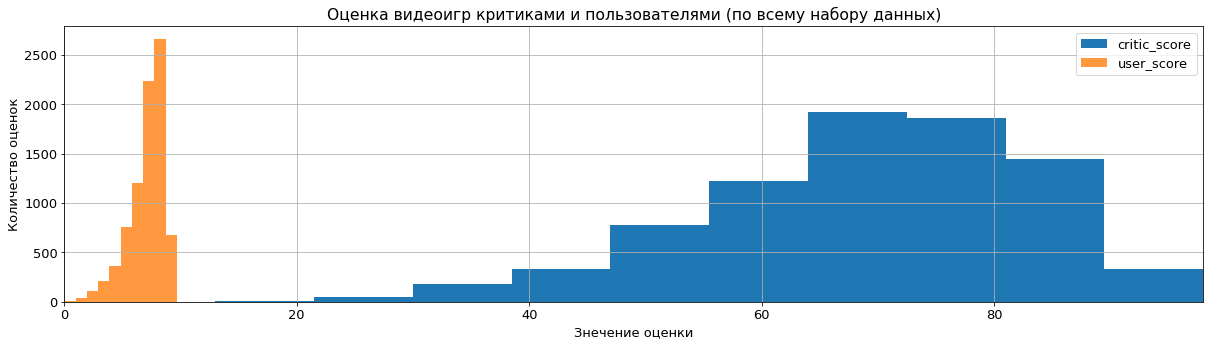

In [43]:
hist(\
    onecolumn_frames_list = [
        data[['critic_score']].dropna(),
        data[['user_score']].dropna()
    ],
    bins=10,
    figsize=(17,5),
    xlab='Знечение оценки',
    ylab='Количество оценок',
    title='Оценка видеоигр критиками и пользователями (по всему набору данных)',
    fontsize=13
)

Ну вот и пришла пора их нормализовать, чтобы было легче сравнивать. Поглядим поближе:

In [44]:
data[['user_score','critic_score']].dropna().describe()

,user_score,critic_score
count,7397.000000,7397.000000
mean,7.167584,69.828038
std,1.439478,13.841905
min,0.500000,13.000000
25%,6.400000,61.000000
50%,7.500000,72.000000
75%,8.200000,80.000000
max,9.600000,98.000000


Да, как и сказано в задании - 0..10 для user_score и 0..100 для critic_score. Корректней - разделить critic_score на 10:

In [45]:
data['critic_score'] = data['critic_score'] / 10

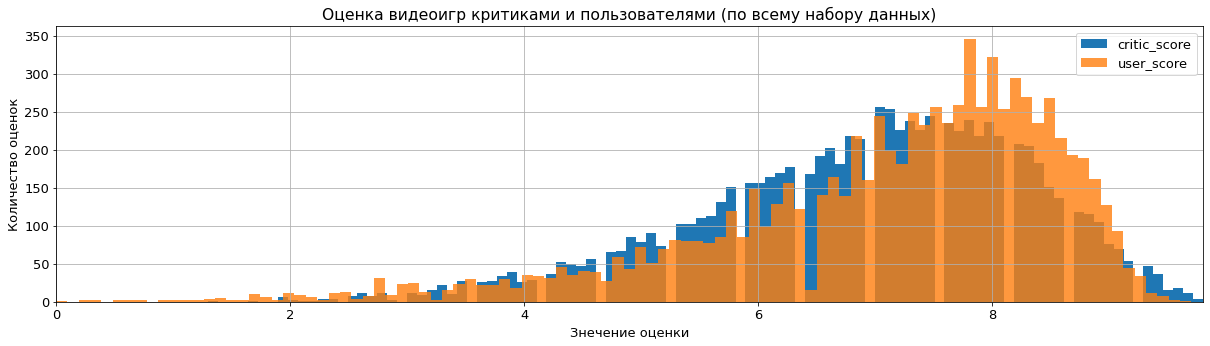

In [46]:
hist(\
    onecolumn_frames_list = [
        data[['critic_score']].dropna(),
        data[['user_score']].dropna()
    ],
    bins=100,
    figsize=(17,5),
    xlab='Знечение оценки',
    ylab='Количество оценок',
    title='Оценка видеоигр критиками и пользователями (по всему набору данных)',
    fontsize=13
)

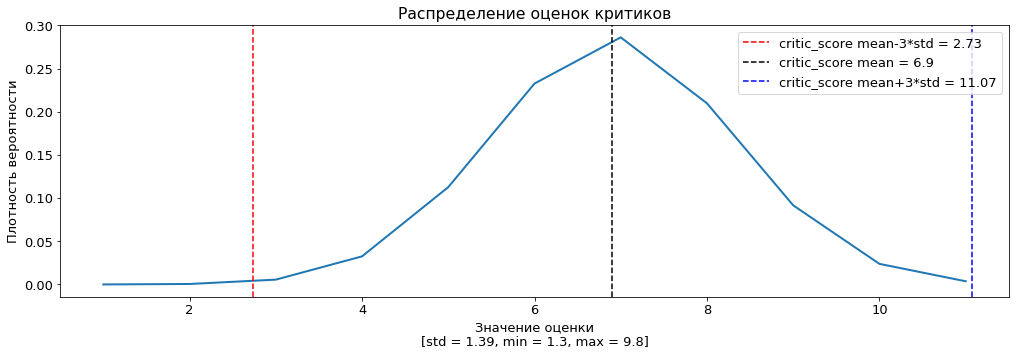

In [47]:
pdf(\
    data[['critic_score']].dropna(),
    figsize=(17,5),
    xlab='Значение оценки',
    ylab='Плотность вероятности',
    title='Распределение оценок критиков',
    fontsize=12
)

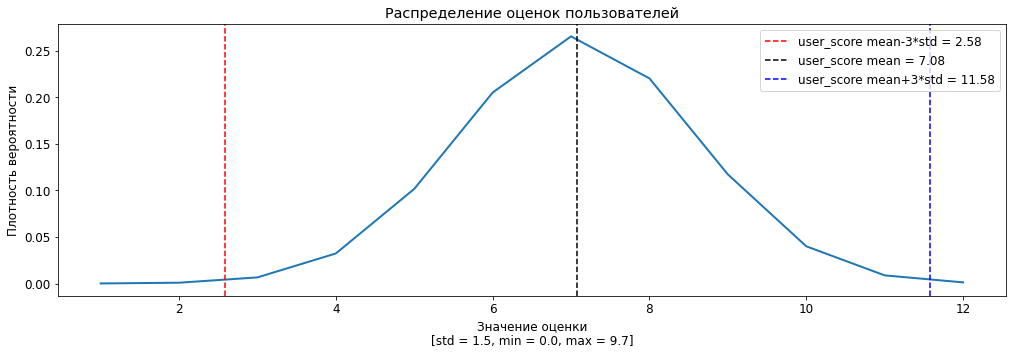

In [48]:
pdf(\
    data[['user_score']].dropna(),
    figsize=(17,5),
    xlab='Значение оценки',
    ylab='Плотность вероятности',
    title='Распределение оценок пользователей',
    fontsize=12
)

Пользователи, все же чуть более эмоциональны - их средняя оценка выше. Критики претенционзы - больше чем пользователи любят экстремально высокие оценки, но в то же время более единообразны - разброс их оценок меньше

По **rating** технических недостатков нет:

In [49]:
data[['rating','name']].dropna().pivot_table(index='rating', values=['name'],aggfunc=['count'])

,count
,name
rating,
AO,1
E,3989
E10+,1419
EC,8
K-A,3
M,1563
RP,3
T,2961


Однако, мелочность по ряду категорий заставляет задуматься, нужны ли они нам. Может быть это "хиты продаж"?

In [50]:
data[['na_sales','eu_sales','jp_sales','other_sales']].dropna().describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16711.000000,16711.000000,16711.000000,16711.000000
mean,0.263334,0.145063,0.077634,0.047348
std,0.813609,0.503390,0.308888,0.186752
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


In [51]:
data.query('(rating == "AO") or (rating == "EC") or (rating == "K-A") or (rating == "RP")')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
656,theme hospital,PC,1997.0,Strategy,2.30,0.10,0.00,0.00,NaN,9.0,K-A
875,grand theft auto: san andreas,XB,2005.0,Action,1.26,0.61,0.00,0.09,9.3,8.6,AO
903,parappa the rapper,PS,1996.0,Misc,0.26,0.16,1.46,0.03,9.2,7.4,K-A
4297,nickelodeon team umizoomi,DS,2011.0,Action,0.42,0.00,0.00,0.03,NaN,NaN,EC
5034,sesame street: elmo's a-to-zoo adventure,Wii,2010.0,Misc,0.35,0.00,0.00,0.02,NaN,NaN,EC
6046,sesame street: cookie's counting carnival,Wii,2010.0,Misc,0.27,0.00,0.00,0.02,NaN,NaN,EC
6764,dora the explorer: journey to the purple planet,PS2,2005.0,Adventure,0.12,0.09,0.00,0.03,NaN,7.0,EC
7586,"ni hao, kai-lan: new year's celebration",DS,2009.0,Misc,0.19,0.00,0.00,0.01,NaN,NaN,EC
9960,dora the explorer: journey to the purple planet,GC,2005.0,Adventure,0.09,0.02,0.00,0.00,NaN,7.0,EC
13065,sesame street: cookie's counting carnival,PC,2010.0,Misc,0.05,0.00,0.00,0.00,NaN,NaN,EC


Да, есть пара хитов. Но на фоне общей выборки - их мало, да и годы - у хитов - аж 1997 и 2005, вряд ли нам это поможет в прогнозе. Остальное - вообще середняки. Отбрасываем все без особых сожалений:

In [52]:
data = data.query('not ((rating == "AO") or (rating == "EC") or (rating == "K-A") or (rating == "RP"))')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16696 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16696 non-null  object 
 1   platform         16696 non-null  object 
 2   year_of_release  16542 non-null  float64
 3   genre            16696 non-null  object 
 4   na_sales         16696 non-null  float64
 5   eu_sales         16696 non-null  float64
 6   jp_sales         16696 non-null  float64
 7   other_sales      16696 non-null  float64
 8   critic_score     8130 non-null   float64
 9   user_score       8245 non-null   float64
 10  rating           9932 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


С **genre** все хорошо:

In [53]:
data['genre'].value_counts()

Action          3367
Sports          2347
Misc            1744
Role-Playing    1498
Shooter         1323
Adventure       1301
Racing          1248
Platform         887
Simulation       873
Fighting         849
Strategy         679
Puzzle           580
Name: genre, dtype: int64

Проверим, нет ли где "перепутанных" жанров:

In [54]:
dup_genres = data[['name','genre','year_of_release']]\
    .groupby(by=['name','genre','year_of_release'])\
    .agg({'genre':'count'})\
    .rename(columns={'genre':'count'})\
    .reset_index()\
    .sort_values(by=['name'])
dup_genres[dup_genres.duplicated(subset=['name','year_of_release'],keep=False)]

,name,genre,year_of_release,count
9718,steins;gate: hiyoku renri no darling,Action,2012.0,1
9720,steins;gate: hiyoku renri no darling,Adventure,2012.0,1


In [55]:
data.query('name =="steins;gate: hiyoku renri no darling"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11461,steins;gate: hiyoku renri no darling,X360,2011.0,Adventure,0.0,0.0,0.08,0.0,NaN,NaN,NaN
12652,steins;gate: hiyoku renri no darling,PSP,2012.0,Action,0.0,0.0,0.06,0.0,NaN,NaN,NaN
15543,steins;gate: hiyoku renri no darling,PS3,2012.0,Adventure,0.0,0.0,0.02,0.0,NaN,NaN,NaN


Отдельно отметим, что игра, видимо, вышла для XBOX на год раньше, что дает нам чуть более "расширенную" логику поиска, чем та, которую мы использовали. Но по факту - это не очень интересно в принципе: мало (не делает погоды) + порт с PS3 на PSP вполне мог быть и не совсем портом, а полноценным ремейком/дополнением со сменой жанра. Оставляем.

Добавим колонку с суммарными продажами и посмотрим на продажи как по регионам, так и в сумме:

In [56]:
data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

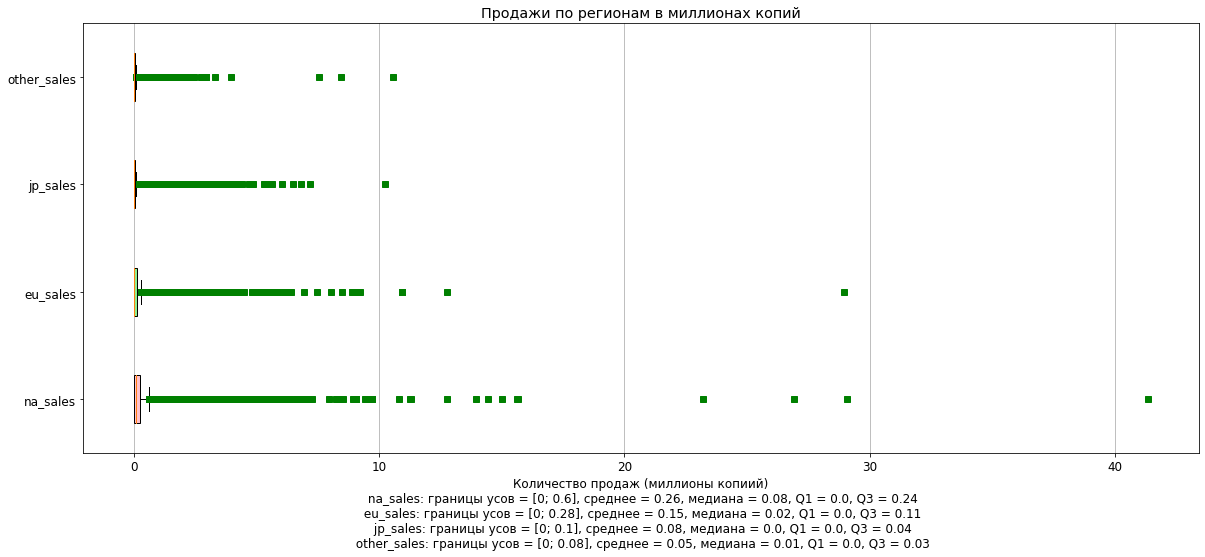

In [57]:
boxplot(
    onecolumn_frames_list = [ 
        data[['na_sales']], 
        data[['eu_sales']], 
        data[['jp_sales']], 
        data[['other_sales']] 
    ],
    figsize=(17,8),
    xlab='Количество продаж (миллионы копиий)',
    title='Продажи по регионам в миллионах копий',
    fontsize=15
)

Условная категория "основная масса игр":

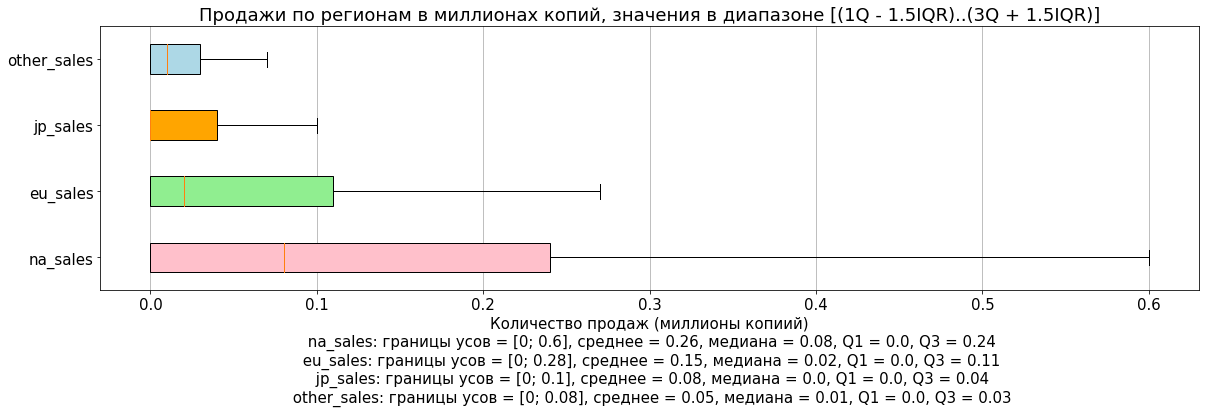

In [58]:
boxplot(
    onecolumn_frames_list = [ 
        data[['na_sales']], 
        data[['eu_sales']], 
        data[['jp_sales']], 
        data[['other_sales']] 
    ],
    figsize=(17,6),
    xlab='Количество продаж (миллионы копиий)',
    title='Продажи по регионам в миллионах копий, значения в диапазоне [(1Q - 1.5IQR)..(3Q + 1.5IQR)]',
    fontsize=15,
    showfliers=False
)

Условная категория "популярные"

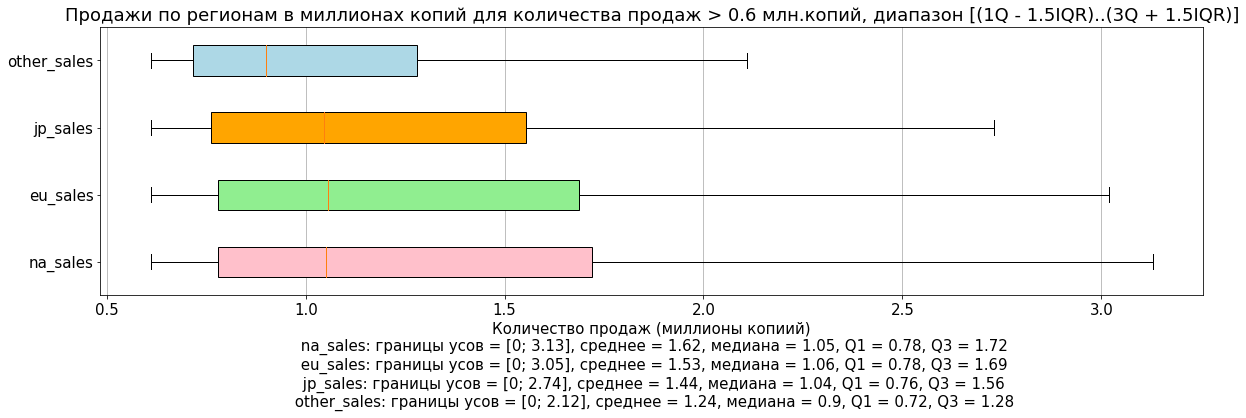

In [59]:
boxplot(
    onecolumn_frames_list = [ 
        data[['na_sales']].query('na_sales > 0.6' ),
        data[['eu_sales']].query('eu_sales > 0.6'), 
        data[['jp_sales']].query('jp_sales > 0.6'), 
        data[['other_sales']].query('other_sales > 0.6') 
    ],
    figsize=(17,6),
    xlab='Количество продаж (миллионы копиий)',
    title='Продажи по регионам в миллионах копий для количества продаж > 0.6 млн.копий, диапазон [(1Q - 1.5IQR)..(3Q + 1.5IQR)]',
    fontsize=13,
    showfliers=False
)

Условная категория "хиты":

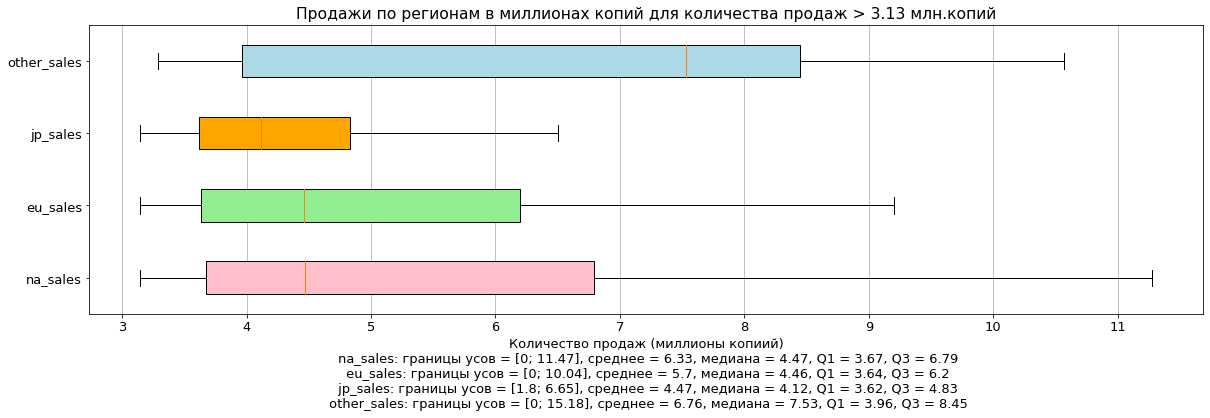

In [60]:
boxplot(
    onecolumn_frames_list = [ 
        data[['na_sales']].query('na_sales > 3.13' ),
        data[['eu_sales']].query('eu_sales > 3.13'), 
        data[['jp_sales']].query('jp_sales > 3.13'), 
        data[['other_sales']].query('other_sales > 3.13') 
    ],
    figsize=(17,6),
    xlab='Количество продаж (миллионы копиий)',
    title='Продажи по регионам в миллионах копий для количества продаж > 3.13 млн.копий',
    fontsize=13,
    showfliers=False
)

Условная категория "мегахиты":

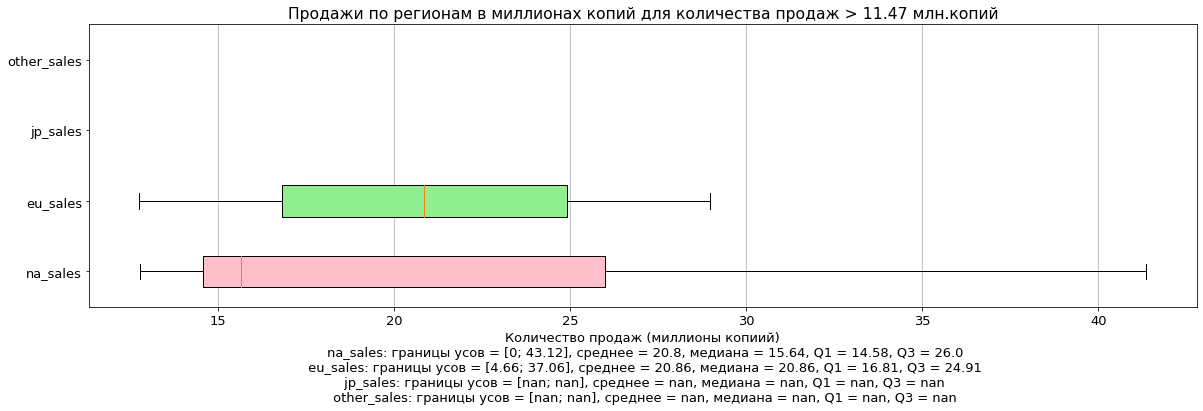

In [61]:
boxplot(
    onecolumn_frames_list = [ 
        data[['na_sales']].query('na_sales > 11.47' ),
        data[['eu_sales']].query('eu_sales > 11.47'), 
        data[['jp_sales']].query('jp_sales > 11.47'), 
        data[['other_sales']].query('other_sales > 11.47') 
    ],
    figsize=(17,6),
    xlab='Количество продаж (миллионы копиий)',
    title='Продажи по регионам в миллионах копий для количества продаж > 11.47 млн.копий',
    fontsize=16
)

Чуть подробнее "картина в целом" и общее сравнение:

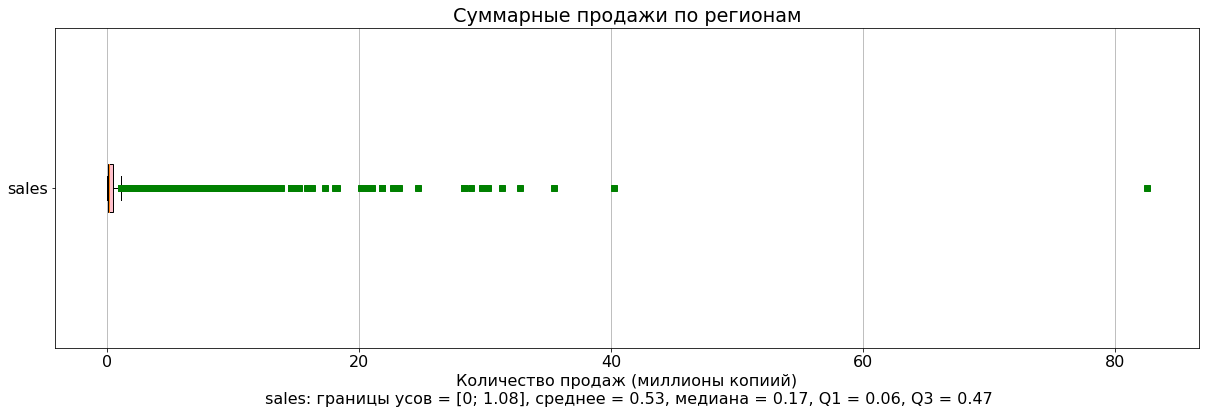

In [62]:
boxplot(
    onecolumn_frames_list = [ 
        data[['sales']]
    ],
    figsize=(17,6),
    xlab='Количество продаж (миллионы копиий)',
    title='Суммарные продажи по регионам',
    fontsize=15
)

In [63]:
data[['na_sales','eu_sales','jp_sales','other_sales','sales']].describe()

,na_sales,eu_sales,jp_sales,other_sales,sales
count,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000
mean,0.263250,0.145129,0.077616,0.047377,0.533371
std,0.813768,0.503591,0.308834,0.186832,1.548901
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.030000,0.470000
max,41.360000,28.960000,10.220000,10.570000,82.540000


А топ-3 "глобальных хитов продаж всех времен и народов в штуках" дает Nintendo. Умеют ребята делать игры:

In [64]:
data.query('sales > 35')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,wii sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,82.54
1,super mario bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,mario kart wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,35.52



>**<span style="color:green">Здесь тоже ноль замечаний. Сверх тщательный анализ и отличная работа с визуализациями. Получилось очень наглядно и аргументировано. Так держать! ;) </span>**


## Исследовательский анализ данных

Мы уже смотрели, сколько игр выпускалось в разные годы. Очевидно, что наш "актуальный период" - с момента начала стабилизации общего числа выпускаемых игр после спада до текущего момента; это 2014-2016 годы:

In [65]:
data[['year_of_release']]\
    .dropna()\
    .astype({'year_of_release':'int32'})['year_of_release']\
    .value_counts()\
    .to_frame().reset_index()\
    .sort_values(by='index')\
    .query('index > 2006')
    

,index,year_of_release
3,2007,1202
0,2008,1440
1,2009,1429
2,2010,1266
4,2011,1151
10,2012,661
13,2013,547
12,2014,581
11,2015,606
14,2016,502


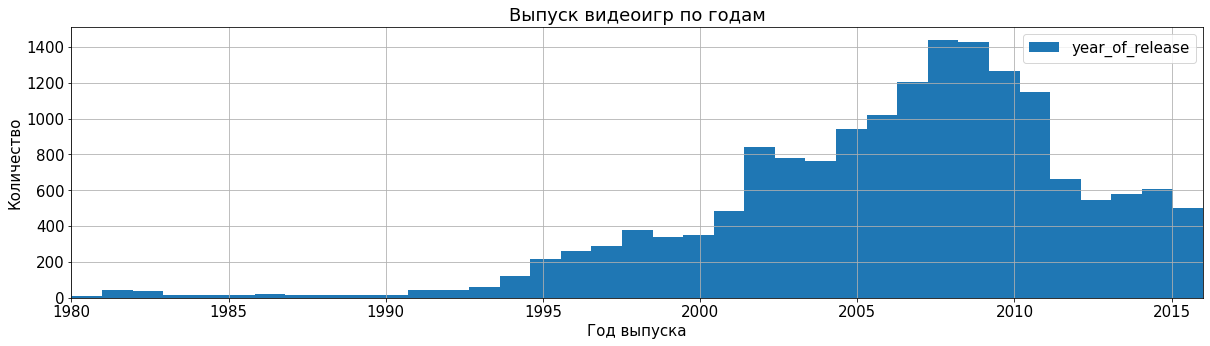

In [66]:
hist(\
    onecolumn_frames_list = [
        data[['year_of_release']].dropna().astype({'year_of_release':'int32'}), 
    ],
    bins=37,
    figsize=(17,5),
    xlab='Год выпуска',
    ylab='Количество',
    title='Выпуск видеоигр по годам',
    fontsize=13
)

Сколько в среднем живут платформы? 

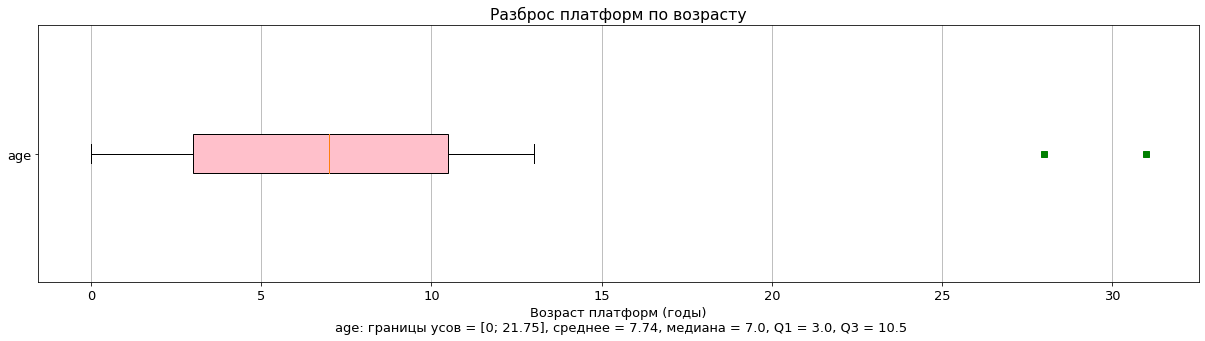

In [67]:
platform_lifetime = data[['platform','year_of_release']]\
    .dropna()\
    .astype({'year_of_release':'int32'})\
    .pivot_table(index=['platform'],aggfunc=['min','max'])\
    .rename(columns={('min','year_of_release',''): 'min'})\
    .reset_index()
platform_lifetime.columns = ['platform','min','max']
platform_lifetime['age'] = platform_lifetime['max'] - platform_lifetime['min']
boxplot(
    onecolumn_frames_list = [ 
        platform_lifetime[['age']]
    ],
    figsize=(17,5),
    xlab='Возраст платформ (годы)',
    title='Разброс платформ по возрасту',
    fontsize=15
)

In [68]:
platform_lifetime[['age']].query("(age > 0) and (age < 21.75)").describe()

,age
count,26.000000
mean,6.961538
std,3.583080
min,1.000000
25%,4.000000
50%,7.500000
75%,10.000000
max,13.000000


Можно утверждать, что среднее время жизни платформы составляет 7.5 лет. Есть платформы-долгожители, **но для прогнозирования в целях повышения продаж целесообразно делать ставку на платформы, релизы на которых появились не поздее 7.5/2 = 3.75 года назад (с учетом процесса естественного роста и последующего угасания платформ), что для нашего случая будет 2012 год**. 

>**<span style="color:green">По определению среднего периода жизни платформ - отличное решение, так же похвалю тебя за то, что построил бокслпот по возрасту платформ — так мы сходу смогли выяснить все интересующие нас параметры распределения. По определению актуального периода тоже полностью согласен.</span>**

Кто лидеры в разрезе продаж по платформам и при этом имеет релизы после 2012 года?

In [69]:
sales_leading_platforms = data.query('year_of_release > 2012')[['platform','sales']]\
    .pivot_table(index='platform', aggfunc={'sales':'sum'})\
    .reset_index()\
    .sort_values(by='sales',ascending=False)
sales_leading_platforms

,platform,sales
4,PS4,314.14
3,PS3,181.43
10,XOne,159.32
0,3DS,143.25
9,X360,136.80
8,WiiU,64.63
2,PC,39.71
6,PSV,32.99
7,Wii,13.66
5,PSP,3.74


А что у этих лидеров с динамикой?

In [70]:
leaders_top_size = 30 # это расчеты, визуализация - через одну ячейку
leading_sales_freq_by_year = data[data.platform.isin(sales_leading_platforms["platform"].head(leaders_top_size))]\
    [['platform','year_of_release','sales']]\
    .dropna(subset=['platform','year_of_release','sales'])\
    .astype({'year_of_release':'int32'})\
    .pivot_table(index=['platform','year_of_release'],aggfunc={'sales':'count'})\
    .reset_index()

In [71]:
def leaders_race(except_platforms=[]):
    series_name_x_y_dict = {}
    for platform in sales_leading_platforms['platform'].head(leaders_top_size):
        if platform not in except_platforms:
            series_name_x_y_dict[platform] = {
                'x': leading_sales_freq_by_year.query('platform == @platform')['year_of_release'],
                'y': leading_sales_freq_by_year.query('platform == @platform')['sales'],
             }   
    line(
        series_name_x_y_dict, 
        xlab='Год продаж',
        ylab='Количество продаж (млн. шт.)', 
        title='Объемы продаж платформ по годам', 
        figsize=(17,6), 
        fontsize=14)

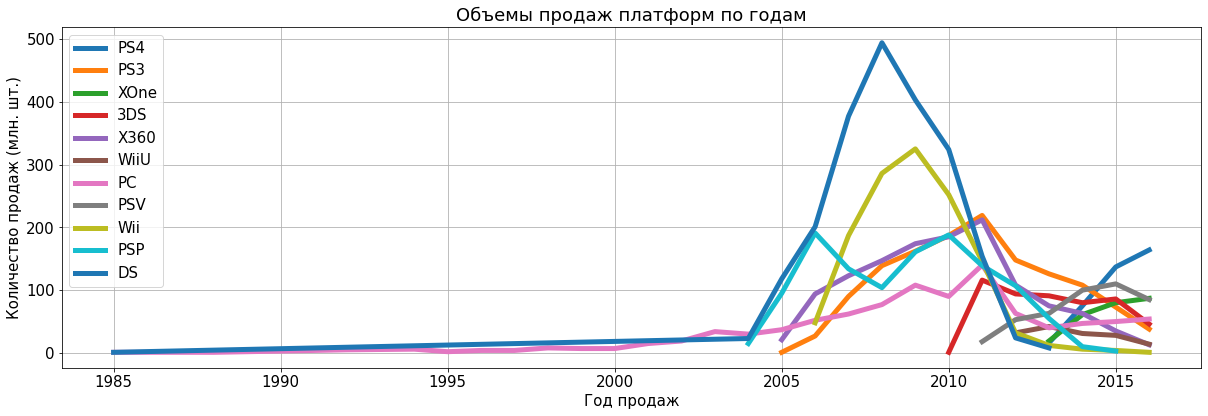

In [72]:
leaders_race()

 Уберем "умирающих", а также явную ошибку восстановления **year_of_release** для Nintendo DS, которая тянет ее "релиз-родлсловную" в 1985 год:

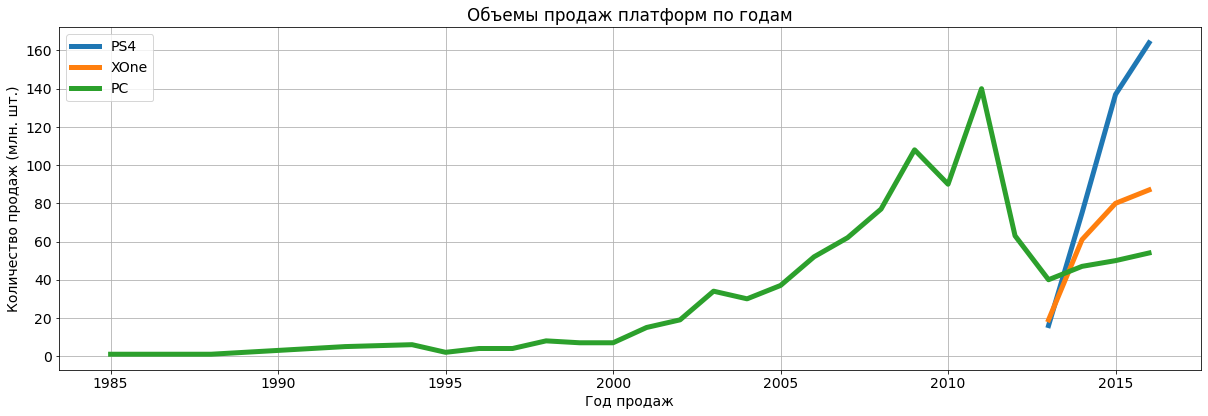

In [73]:
leaders_race(except_platforms=['PS3','X360','3DS','WiiU','Wii','DS','PSP','PSV'])

Ну вот и "Три белых коня": PS4, XboxOne и "вечный" PC. **Именно в закупку игр для этих трех платформ и должен вложиться Стримчик, если хочет иметь более высокую вероятность заработать в 2017, чем просто выбрав платформы наугад**

>**<span style="color:green">И здесь все тоже ожидаемо хорошо!</span>**

Посмотрим, в каком соотношени лучше вложиться:

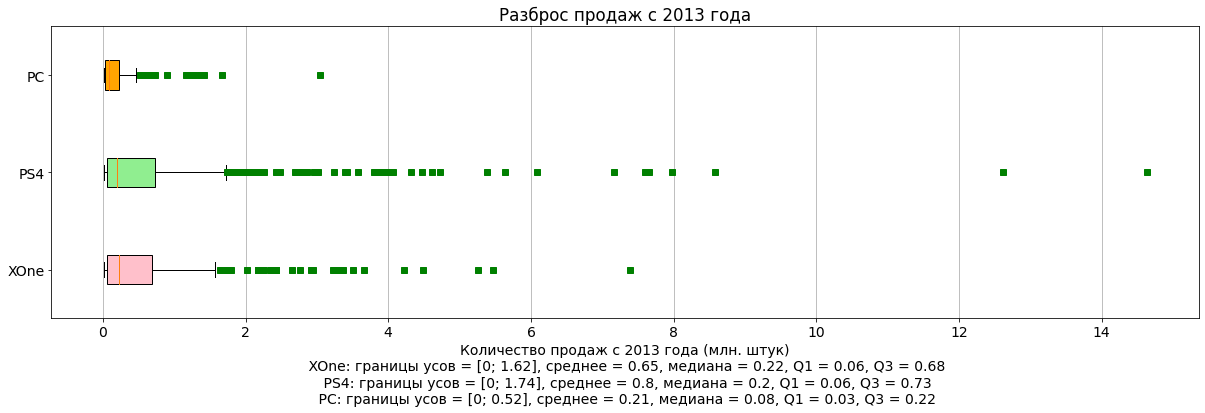

In [74]:
data\
    .dropna(subset=['platform','year_of_release','sales'])\
    .query('year_of_release >= 2013')\
    .query('(platform == "XOne") or (platform == "PS4") or (platform == "PC")')\
    [['platform','sales']]


boxplot(
    onecolumn_frames_list = [ 
        data
            .dropna(subset=['platform','year_of_release','sales'])\
            .query('year_of_release >= 2013 and platform == "XOne"')[['sales']].rename(columns={'sales':'XOne'}),
        data
            .dropna(subset=['platform','year_of_release','sales'])\
            .query('year_of_release >= 2013 and platform == "PS4"')[['sales']].rename(columns={'sales':'PS4'}),
        data
            .dropna(subset=['platform','year_of_release','sales'])\
            .query('year_of_release >= 2013 and platform == "PC"')[['sales']].rename(columns={'sales':'PC'}),
        
    ],
    figsize=(17,6),
    xlab='Количество продаж с 2013 года (млн. штук)',
    title='Разброс продаж с 2013 года',
    fontsize=15
)

Хитов и Мегахитов на PS4 выходит явно больше, поэтому, **если бы особенности продаж были бы идентичны для всех регионов**, то для снижения рисков вложения стоит распределить в соотношении ~= 4:5:1 (по средним): 

In [75]:
leader_investment_shares = pd.DataFrame({"XOne": [65], "PS4": [80], "PC": [21]})
sum = leader_investment_shares.sum(axis=1)
leader_investment_shares.apply(lambda x: x / sum)


,XOne,PS4,PC
0,0.391566,0.481928,0.126506


Какова зависимость продаж игр для этих платформ от мнения критиков?

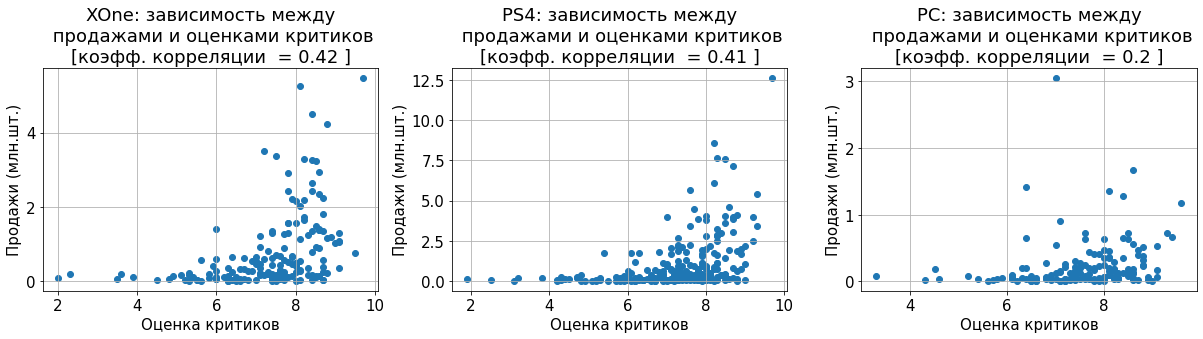

In [76]:
scatter_data = {}
for platform in leader_investment_shares.columns:
    scatter_data[f'{platform}: зависимость между\n продажами и оценками критиков'] = {
        'names':['Оценка критиков','Продажи (млн.шт.)'],
        'values': [
            data\
                .dropna(subset=['platform','year_of_release','sales','critic_score'])\
                .query('platform == @platform and year_of_release >= 2013')['critic_score'],
            data\
                .dropna(subset=['platform','year_of_release','sales','critic_score'])\
                .query('platform == @platform and year_of_release >= 2013')['sales'],
        ]
    }
scatter(scatter_data,figsize = (17,5),fontsize=16)


Для платформ XOne и PS4 можно "с оглядкой на критиков" (слабая положительная корреляция) вкладываться в закупку конкретных игр. **В целом, для всех трех платформ-лидеров, оценку критиков лучше использовать как "отсечку", например, не вкладываться в игры, которым критики ставят меньше 5.** Но, справедливости ради, стоит отметить, что это слабо работающий критерий, т.к. более 95% игр получили более высокую оценку в актуальном периоде:

In [77]:
data\
    .dropna(subset=['platform','year_of_release','sales','critic_score'])\
    .query('\
        ((platform == "XOne") or (platform == "PS4") or (platform == "PC"))\
        and (year_of_release >= 2013)\
        and (critic_score >= 5)'\
    )[['platform']].count()\
    .to_frame(name = "Количество с оценкой > 5")\
    .assign(share = lambda x: \
            x / data\
                .dropna(subset=['platform','year_of_release','sales','critic_score'])\
                .query('\
                    ((platform == "XOne") or (platform == "PS4") or (platform == "PC"))\
                    and (year_of_release >= 2013)').shape[0])\
                .rename(columns={'share':'Доля игра с оценкой > 5'})


,Количество с оценкой > 5,Доля игра с оценкой > 5
platform,544,0.951049


Посмотрим на распределение продаж в разрезе жанров (поскольку продажи в штуках, нельзя сказать что это рейтинг "самых прибыльных жанров", но не будем придираться к словам):

In [78]:
data[['genre','sales']]\
    .groupby(by=['genre'])\
    .agg({'sales': 'sum', 'sales':'sum'})\
    .reset_index()\
    .sort_values(by='sales',ascending=False)    

,genre,sales
0,Action,1741.76
10,Sports,1331.27
8,Shooter,1052.45
7,Role-Playing,934.56
4,Platform,827.77
3,Misc,799.65
6,Racing,728.66
2,Fighting,447.53
9,Simulation,389.97
5,Puzzle,242.57


"Люди как люди": думать и заморачиваться не любят (Strategy, Advanture и Puzzle - в самом низу рейтинга), а вот "эмоционально кайфануть" (Action, Sports, Shooter) - за милую душу. А верно ли это для продаж 2013+ ?
    

In [79]:
data[['year_of_release','genre','sales']]\
    .dropna()\
    .query('year_of_release >= 2013')\
    .groupby(by=['genre'])\
    .agg({'sales': 'sum', 'sales':'sum'})\
    .reset_index()\
    .sort_values(by='sales',ascending=False)   

,genre,sales
0,Action,322.15
8,Shooter,232.98
10,Sports,150.65
7,Role-Playing,145.89
3,Misc,63.06
4,Platform,42.63
6,Racing,39.89
2,Fighting,35.31
1,Adventure,23.64
9,Simulation,21.76


Да, верно (ну разве что в "рейтинге аутсайдеров" небольшие изменения, но опять же, все жанры - "думающие"). 
**Если Стримчик хочеть побольше продавать, то ему надо вкладываться в закупку игр жанров Action, Shooter и Sports**


>**<span style="color:orange">По анализу жанров можно было еще добавить график с количеством выпущенных игр (в качестве альтернативы можно было построить боксплоты в разбивке по жанрам). Возможно, некоторые жанры берут количеством, в то время как другие, напротив, основной объем продаж генерируют за счёт игр-бестселлеров.</span>**


## Портреты пользователей из различных регионов

Топ-10 жанров по регионам:

In [80]:
def top_sales_by_column(source, column='genre', size=5):
    sales_by = source[[column,'na_sales','eu_sales','jp_sales']]\
        .groupby(by=[column])\
        .agg(['sum'])\
        .reset_index()
    sales_by.columns = [column,'na_sales_sum','eu_sales_sum','jp_sales_sum'] 
    for region in ['na','eu','jp']:
        sales_by[region + '_' + column + '_share'] = \
            sales_by[region + '_sales_sum'] / sales_by[region + '_sales_sum'].sum()        
    tops = []
    for region in ['na','eu','jp']:
        share_column = region + '_' + column + '_share'
        tops.append(
            sales_by[[column, share_column]]\
                .sort_values(by=share_column, ascending=False)\
                .head(size)\
                .rename(columns={column: (region +'_' + column)})\
                .reset_index()\
                .drop(columns=['index'])
        )
    return pd.concat(tops, axis=1)

In [81]:
sales_by_genre = top_sales_by_column(data,'genre', size=10)
sales_by_genre

,na_genre,na_genre_share,eu_genre,eu_genre_share,jp_genre,jp_genre_share
0,Action,0.199610,Action,0.213993,Role-Playing,0.274262
1,Sports,0.155721,Sports,0.155501,Action,0.124572
2,Shooter,0.134746,Shooter,0.130966,Sports,0.104593
3,Platform,0.101360,Racing,0.097603,Platform,0.100958
4,Misc,0.092398,Misc,0.087732,Misc,0.082299
5,Racing,0.081759,Platform,0.082684,Fighting,0.067506
6,Role-Playing,0.075266,Role-Playing,0.077881,Simulation,0.049233
7,Fighting,0.050819,Simulation,0.046850,Puzzle,0.044225
8,Simulation,0.041390,Fighting,0.041406,Racing,0.043762
9,Puzzle,0.027955,Adventure,0.026178,Adventure,0.040359


Картина схожа с общей - лидеры в трех регионах по прежнему Action и Sports, но, видимо, особенности японской культуры выводят на первое место RPG (причем, с солидным объемом), а шутеры вообще выпадают даже из топ-10. **Поскольку Стримчик работает по всему миру, эту особенность надо учесть при выборе игр, которые будет закупать и рекламировать японское региональное отделение, иначе будет риск существенного снижения выручки по данному региону**

Топ долей продаж по платформам, в разрезе только тех, которые нам интересны и только с 2013 года:

In [82]:
sales_by_platform = top_sales_by_column(
    data.query('(platform == "XOne") or (platform == "PS4") or (platform == "PC") and (year_of_release >=2013)'),
    'platform', 
    size=3)
sales_by_platform

,na_platform,na_platform_share,eu_platform,eu_platform_share,jp_platform,jp_platform_share
0,PS4,0.510540,PS4,0.646401,PS4,0.979141
1,XOne,0.437204,XOne,0.236359,XOne,0.020859
2,PC,0.052256,PC,0.117240,PC,0.000000


А вот это уже очень интересно: мы видим региональные особенности, например, **тотальное доминирование PS4 в Японии, 
что конечно же, необходимо учесть при планировании продаж** (отметим также близость к формуле глобальной формуле XOne:PS4:PC = 4:5:1 для Северной Америки).

Самое забавное, что на этой стадии мы можем "поиграть в Госплан" и сформировать "куб закупочных лимитов для регионов, платформ и жанров" (добавив dimension по доле продаж в регионе), что позволит нам ответить,например, на вопрос "какая максимальная сумма от общего закупочного бюджета Стримчика может быть потрачена на закупку и рекламу игр категории X для платформы Y в регионе Z, если динамика продаж 2017 будет соответствовать динамике 2013-2016".


По двум очевидным соображениями мы не будем это делать: первое - в жизни планирование продаж идет "снизу вверх", так что все что мы можем - это дать рекомендацию к обсуждению на базе нашего анализа (хотя контрольная функция в части оценки рисков, которая может быть реализована через такую матрицу, вполне может идти и "сверху вниз"); 
второе - soft deadline и так уже пророчен, не хочется просрочить еще и hard deadline



Ну и на последок, виртуально добавим "dimension" (в наш куб, сделав его гиперкубом) по рейтингу от ESRB (как и в случае с жанром, используем глобальный контекст):

In [83]:
sales_by_esrb = top_sales_by_column(data,'rating', size=10)
sales_by_esrb

,na_rating,na_rating_share,eu_rating,eu_rating_share,jp_rating,jp_rating_share
0,E,0.409882,E,0.392453,E,0.436414
1,T,0.240843,M,0.267421,T,0.333517
2,M,0.237271,T,0.235958,M,0.141513
3,E10+,0.112004,E10+,0.104168,E10+,0.088556


(https://www.esrb.org/ratings-guide/) => (E)veryone практически идентичен для всех трех регионов , (T)een, (M)ature и (E10+)veryone > 10 также почти идентичны для США и Европы, **но для Японии есть особенности, которые нужно будет учесть при планировании региональных продаж (вероятно, там велика относительная доля подростков (T)=13+, которые играют в видеоигры)**

>**<span style="color:red">~~А вот здесь позволю себе не согласиться касательно платформ. Я бы посмотрел на распределение по платформам, при этом не анализируя только перспективные платформы — скорее всего если бы мы посмотрели на все доступные платформы, региональных продажах было бы больше. Выведи, пожалуйста, именно топ-5 платформ для каждого из регионов - это важный инсайт для нашего магазина.~~</span>**

>**<span style="color:green">При этом я просто в восторге от того как ты умело работаешь с функциями и циклами для подобных операций. Очень круто!</span>**

ok, посмотрим на топ-плафтрмы по выборке в целом, но в актуальном периоде:

In [84]:
sales_by_platform = top_sales_by_column(
    data.query('year_of_release >=2013'),
    'platform', 
    size=5)
sales_by_platform

,na_platform,na_platform_share,eu_platform,eu_platform_share,jp_platform,jp_platform_share
0,PS4,0.248418,PS4,0.359502,3DS,0.480854
1,XOne,0.212734,PS3,0.172782,PS3,0.165579
2,X360,0.186553,XOne,0.131453,PSV,0.131825
3,PS3,0.145067,X360,0.108342,PS4,0.113175
4,3DS,0.087268,3DS,0.078887,WiiU,0.077152


Да, здесь ты действительно прав: "умирающие" еще не до конца мертвы и держат значительную долю рынка. А для Японии так вообще 48% продаж пришлось на 3DS, что говорит о том что, скорее всего, эта платформа "не умрет просто так" в следующем году в этом регионе. **Стримчику следует рассматривать значение долей совместно для "умирающих" и "восходящих" лидеров как "минимальную" (для восходящих) и "максимальную" (для умирающих) позицию в долях вложений в закуп игр по платформам на 2017, чтобы не потерять в доходах при условии сохранения тренда**

## Проверка гипотез

**Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

- H<sub>0</sub>: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- H<sub>1</sub>: Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

Для начала, проверим распределения на нормальность и посмотрим на них:

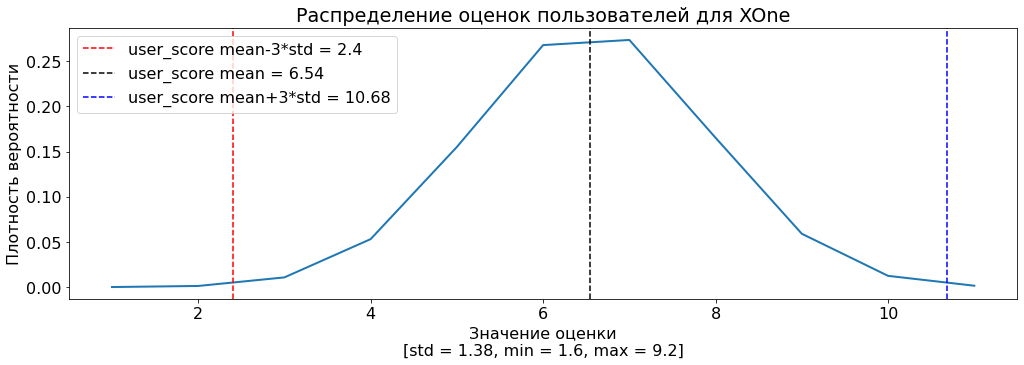

In [85]:
pdf(\
    data.query('platform == "XOne"')[['user_score']].dropna(),
    figsize=(17,5),
    xlab='Значение оценки',
    ylab='Плотность вероятности',
    title='Распределение оценок пользователей для XOne',
    fontsize=13
)

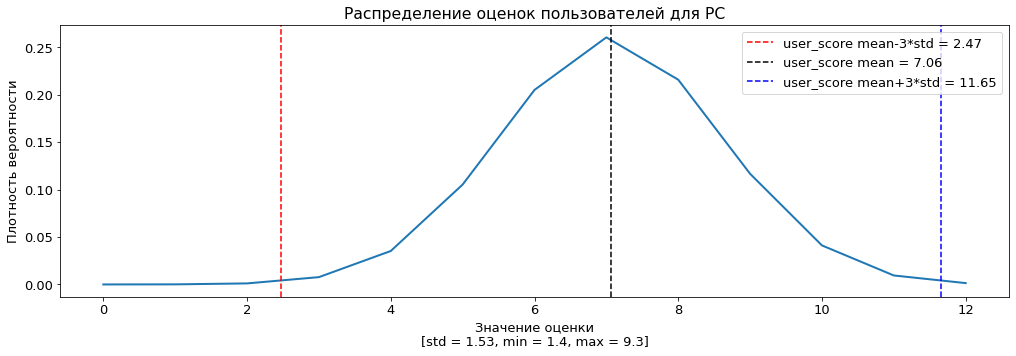

In [86]:
pdf(\
    data.query('platform == "PC"')[['user_score']].dropna(),
    figsize=(17,5),
    xlab='Значение оценки',
    ylab='Плотность вероятности',
    title='Распределение оценок пользователей для PC',
    fontsize=13
)

In [87]:
def normaltest(description, data):
    alpha = 1e-3
    k2, p = st.normaltest(data)
    if p < alpha:
        print(f'Результат теста: отвергаем нулевую гипотезу о том, что {description} распределены нормально, т.к. {p} < {alpha}')
    else: 
        print(f'Результат теста: нельзя отвергнуть нулевую гипотезу о том, что {description} распределены нормально, т.к. {p} > {alpha}')

In [88]:
normaltest('оценки пользователей для платформы XOne', data.query('platform == "XOne"')['user_score'].dropna())

Результат теста: отвергаем нулевую гипотезу о том, что оценки пользователей для платформы XOne распределены нормально, т.к. 7.879350604113152e-06 < 0.001


In [89]:
normaltest('оценки пользователей для платформы PC', data.query('platform == "PC"')['user_score'].dropna())

Результат теста: отвергаем нулевую гипотезу о том, что оценки пользователей для платформы PC распределены нормально, т.к. 1.1090594221056639e-26 < 0.001


Мда, печально, конечно, что наши выборки совсем не нормально распределны. Но "сощурив глаза", будем считать их **приблизительно нормальными** и проведем для них T-тест: 

>**<span style="color:green">Я просто в восторге от того как ты умело работаешь с функциями и циклами для подобных операций. Очень круто!</span>**

In [90]:
def ttest(a, desc_a, b, desc_b):
    a_var = a.var()
    b_var = b.var()
    var_relation =  a_var / b_var if a_var > b_var else b_var / a_var
    ev = var_relation <= 2
    print(f'Подготовка теста: используем equal_vars = {ev}, т.к.')
    print(f'   var({desc_a}) = {a_var}') 
    print(f'   var({desc_b}) = {b_var}') 
    alpha = 0.01
    results = st.ttest_ind(a,b,equal_var=ev) 
    if results.pvalue < alpha:
        print('Результат теста: отвергаем нулевую гипотезу, т.к.', results.pvalue, '<',alpha)
    else: 
        print('Результат тест: нельзя отвергать нулевую гипотезу, т.к.', results.pvalue, '>',alpha)

In [91]:
ttest(
    data.query('platform == "XOne"')['user_score'].dropna(),
    'оценка пользователей для XOne',
    data.query('platform == "PC"')['user_score'].dropna(),
    'оценка пользователей для PC'
)

Подготовка теста: используем equal_vars = True, т.к.
   var(оценка пользователей для XOne) = 1.915955476753349
   var(оценка пользователей для PC) = 2.3337595920703293
Результат теста: отвергаем нулевую гипотезу, т.к. 2.3587461516847897e-05 < 0.01


Ожидаемо, исходя из графиков: средние оценки для XOne и PC не одинаковые

**Гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.**

- H<sub>0</sub>: Средние пользовательские рейтинги жанров Action и Sports одинаковые.
- H<sub>1</sub>: Средние пользовательские рейтинги жанров Action и Sports не одинаковые (разные)


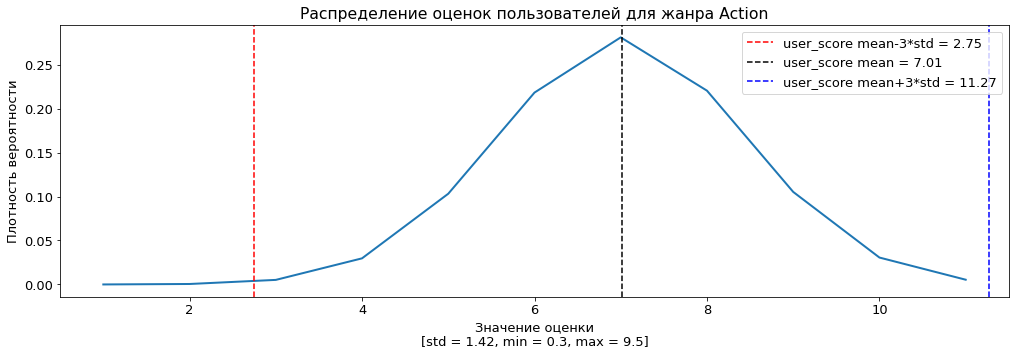

In [92]:
pdf(\
    data.query('genre == "Action"')[['user_score']].dropna(),
    figsize=(17,5),
    xlab='Значение оценки',
    ylab='Плотность вероятности',
    title='Распределение оценок пользователей для жанра Action',
    fontsize=13
)

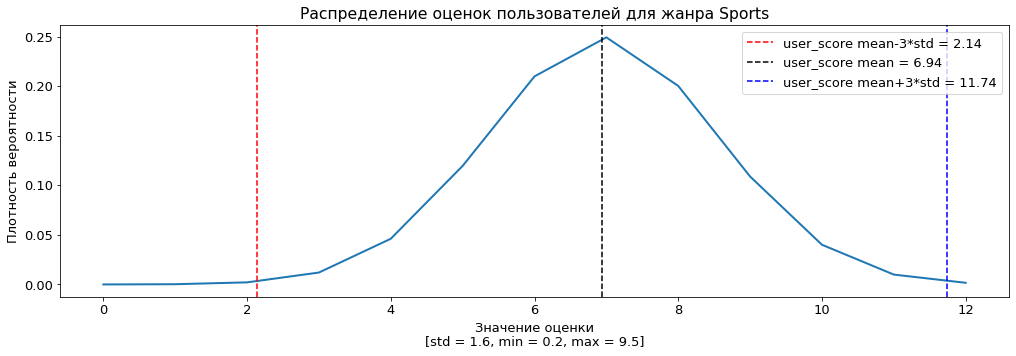

In [93]:
pdf(\
    data.query('genre == "Sports"')[['user_score']].dropna(),
    figsize=(17,5),
    xlab='Значение оценки',
    ylab='Плотность вероятности',
    title='Распределение оценок пользователей для жанра Sports',
    fontsize=13
)

In [94]:
normaltest('оценки пользователей для жанра Action', data.query('genre == "Action"')[['user_score']].dropna())

Результат теста: отвергаем нулевую гипотезу о том, что оценки пользователей для жанра Action распределены нормально, т.к. [5.86382322e-66] < 0.001


In [95]:
normaltest('оценки пользователей для жанра Sports', data.query('genre == "Sports"')[['user_score']].dropna())

Результат теста: отвергаем нулевую гипотезу о том, что оценки пользователей для жанра Sports распределены нормально, т.к. [1.33877938e-42] < 0.001


In [96]:
ttest(
    data.query('genre == "Action"')['user_score'].dropna(),
    'оценка пользователей для жанра Action',
    data.query('genre == "Sports"')['user_score'].dropna(),
    'оценка пользователей для жанра Sports'
)

Подготовка теста: используем equal_vars = True, т.к.
   var(оценка пользователей для жанра Action) = 2.0122534480955756
   var(оценка пользователей для жанра Sports) = 2.560713975211064
Результат тест: нельзя отвергать нулевую гипотезу, т.к. 0.19672491328361294 > 0.01


**Тестирование показало, что оценки пользователей для категорий Action и Sports одинаковые** (было бы странно ожидать иного при почти идентичных mean и близких std в рамках нормального распределения)

>**<span style="color:green">С формулирокой и проверкой гипотез у тебя полнейший порядок. Очень здорово, что ты проверяешь наши данные на нормальность и посчитал дисперсию наших выборок и учёл это при проведении тестов. Браво!</span>**

>**<span style="color:green">JFYI: чтобы нам не приходилось дополнительно фильтровать выборки от пропусков, можно передавать в параметры теста `nan_policy = 'omit'` - это скажет тесту, чтобы он не обращал внимание на пропуски и все отработает должным образом. И еще один момент, чтобы оперативно проверять распределения на нормальность можно использовать `qqplot` - часто это будет быстрее и нагляднее ;)</span>**

## Общий вывод

Если Стримчик хочет успешно продавать игры в 2017 году, то ему необходимо:
    1. Ориентироваться на дистрибуцию игр для платформ Sony PS4, Microfost XBox One и PC
    2. При планировании закупок с целью последующих продаж, принимать во внимание региональные особенности (и обращать особое внимание на Японию) в разрезах жанров и платформ.
    3. На мнение критиков целесообразно смотреть как на "отсечку": не приобретать игры с оценкой < 5 для последущей перепродажи.

>**Спасибо тебе за сдачу твоего проекта. Работа получилась просто замечательная и хорошо структурированная. Видно, что ты отлично справился с материалами первых трёх спринтов и уверенно применяешь полученные знания навыки на практике. Для зачёта сборного проекта тебе осталось совсем чуть-чуть поработать и исправить буквально один недочёт. Также на будущее я рекомендую тебе уделять чуть больше внимания оформлению и структуре проектов: нам не помешает выделять промежуточные шаги заголовками в ячейках `markdown`, а также в начале работы составить небольшое саммари и оглавление (часто его еще делают интерактивным для удобства навигации).**
>
>**Отдельно хочу тебя похвалить за твой комплексный подход к оформлению проекта, твой чистый код и развернутые выводы и комментарии, а также за качественную работу с функциями и циклами. Молодец!**
>
>**Буду ждать твой доделанный проект на повторную проверку. Успехов!**

>>**Update: Привет еще раз! Теперь все точно идеально, и твой первый сборный проект зачтен. Поздравляю! ;)**
